In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import pandas as pd
df = pd.read_csv('A2Q1.csv', header=None)

In [3]:
X = np.array(df)  # Load the data into a numpy array

In [5]:
X.shape

(400, 50)

In [21]:
def gaussian(x,mu,cov):  # Calculate Gaussian PDF value
  if np.linalg.det(cov)==0:
      cov += 0.1*np.eye(50)
  c = -0.5 * ((x.T - mu.T).T @ np.linalg.inv(cov)) @ (x.T - mu.T)
  c = np.exp(c)
  c /= np.sqrt((2 * np.pi) ** 50 * np.linalg.det(cov))
  return c

In [7]:
def expectation(X, mu, cov, pi):  # Expectation Step
  lamda = np.zeros((X.shape[0],4)) # Initialize with zeros
  for i in range(X.shape[0]):
    sum = 0
    for k in range(4):
      g = gaussian(X[i],mu[k],cov[k])*pi[k]  # Calculate PDF value
      lamda[i][k] = g
      sum = sum + g
    if sum!=0:
      lamda[i] = lamda[i]/sum     # Final results
  return lamda

In [16]:
def maximization(X, lamda):   # Maximization step
  pi = np.zeros(4)            # Initialization
  mu = np.zeros((4,X.shape[1]))
  cov  = np.zeros((4,X.shape[1],X.shape[1]))

  for k in range(4):               # Calculate pi
    for i in range(X.shape[0]):
      pi[k] = pi[k] + lamda[i][k]

  for k in range(4):               # calculate mu
    for j in range(50):
      for i in range(400):
        mu[k][j] = mu[k][j] + lamda[i][k]*X[i][j]

  for k in range(4):               # Calculate cov
    for j in range(400):
      cov[k] = cov[k] + ((X[j]-mu[k]).T  @ (X[j]-mu[k]))*lamda[j][k]

  for k in range(4):               # Final results
    if pi[k] != 0:
      mu[k] = mu[k]/pi[k]
      cov[k] = cov[k]/pi[k]

  pi = pi/400

  return pi, mu, cov

In [53]:
def log_likelihood(X,pi,mu,cov):  # Calculate log likelihood
  sum = 0
  for i in range(400):
    temp = 0
    for k in range(4):
      temp = temp+ gaussian(X[i],mu[k],cov[k])*pi[k]
    sum = sum + math.log(temp)
  return sum

In [25]:
def error(mu_new, cov_new, pi_new, mu, cov, pi):
  # Calculate the error between successive iterations
  err = np.linalg.norm(pi_new-pi)**2
  for i in range(mu.shape[0]):
    for j in range(mu.shape[1]):
      err = err + (mu[i][j] - mu_new[i][j])**2
      for k in range(cov.shape[2]):
        err = err + (cov[i][j][k] - cov_new[i][j][k])**2
  return err

In [46]:
def obj(X, mu, pi):
  err=0
  for k in range(4):
    for i in range(400):
      err+=(np.linalg.norm(X[i]-mu[k])**2)*pi[k]
  return err

In [58]:
def EM(X):   # EM algorithm main code
  pi = np.random.rand(4)  # Randomize pi and mu
  pi = pi/np.sum(pi)
  cov = np.empty((4,50,50))
  for i in range(4):      # Initialize cov to be invertible
    G = np.random.random((50,50))
    G = G @ G.T
    cov[i] = G
  mu = np.random.rand(4,50)
  it=0
  err = 1
  logl=np.array([])       # Array to maintain log likelihood values

  while it<50:            # Set constant number of iterations
    lamda = expectation(X,mu,cov,pi) # Expectation step
    pi_new, mu_new, cov_new = maximization(X,lamda)  # Maximization step
    logl = np.append(logl,log_likelihood(X,pi_new,mu_new,cov_new))
    err = error(mu_new,cov_new,pi_new,mu,cov,pi)
    mu = mu_new                     # Update parameters
    pi = pi_new
    cov = cov_new
    it = it+1                       # Update iterations

  return mu, cov, pi, lamda, logl

In [59]:
def EM_iter(X):
  log_likelihood = np.zeros(20)
  obj_val=0
  for i in range(100):
    mu, cov, pi, lamda, logl = EM(X)
    log_likelihood = log_likelihood + logl
    obj_val += obj(X,mu,pi)
  return log_likelihood, obj_val

In [55]:
log_likelihood, obj_val = EM_iter(X)

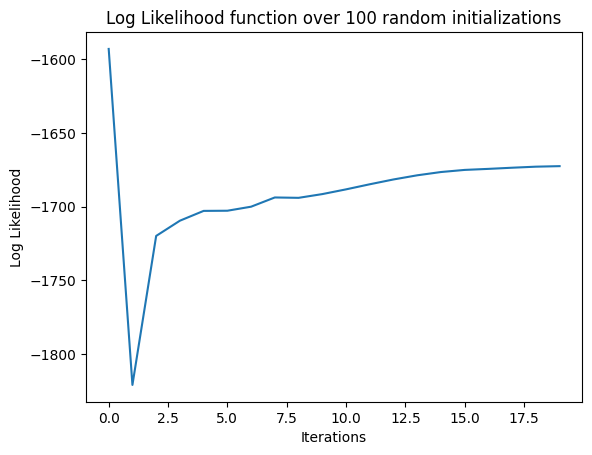

In [49]:
log_likelihood /= 100
plt.plot(log_likelihood)

plt.title('Log Likelihood function over 100 random initializations')
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.show()

In [57]:
obj_val /=100 # Objective function
obj_val

7.089822117560206